In [2]:
#!pip install --upgrade pip
!pip3 install opencv-python matplotlib imutils jupyter sklearn tensorflow
!apt-get install libgl1-mesa-glx

In [1]:
## import packages
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from imutils import paths
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import save_model, load_model, Model
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, AveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam

In [3]:
## data preprocessing
imagePath = "./all/train"
imagePaths = list(paths.list_images(imagePath))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    data.append(image)
    labels.append(label)

In [7]:
data = np.array(data) / 255.0
labels = np.array(labels)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels) #정수로 바꿈. 라벨이 1,2,3, 처럼 숫자로 변경됨.
labels = to_categorical(integer_encoded) # 라벨이 0,1,2, 에서 [1,0,0], [0,1,0] 인식하게 좋게 변경됨

#data 를 160:40 으로 분할함.
#train data : x_train(256*256*3 행렬), y_train(라벨)
#test data : y_val(256*256*3 행렬), y_val(라벨)

(x_train, x_val, y_train, y_val) = train_test_split(data, labels, test_size=0.20, stratify=labels)

ValueError: y should be a 1d array, got an array of shape (200, 3) instead.

이미지 특성 모델은 보통 다음과 같은 구조를 지닌다. 

합성곱 신경망 (그림의 특성을 추출) - Average2DPoolling 및 평탄화 (Flatten) - Dense layer 를 이용해서 분류
        (베이스 모델)                                                        (헤드모델)
        
저희 데이터는 겨우 160개 -> 재대로 훈련을 하기에는 부족하다. 
그래서 이미 다른 좋은 데이터로 훈련시켜놓은 합성곱 신경망을 가져와서 쓸 것이다. (inceptionV3) -> google net
그리고 우리의 데이터는 이미 훈련된 basemodel 을 건드리지 않고, headmodel 만 훈련을 시킬 것이다. 

이것을 전이학습 (transfer learning) 이라고 합니다.
원래 inceptionV3 도 Dense layer 부분이 있음. 단 이 부분은 원래 데이터 분류인 1000개 분류를 합니다. 
but 우리는 3개(폐렴, 정상, Covid) -> headmodel 부분을 재구성 해야합니다. 

현재모델 : 합성곱 신경망 (inception V3) - Average2DPoolling 및 평탄화 (Flatten) - 128 -> 128 -> 3 구조의 Dense layer

이런 전이학습의 경우에는 학습률을 평소보다 낮춰서 진행합니다.
(평소에는 learning_rate =0.001 정도라면, 전이학습은 0.00001 로 진행해야 한다.


In [11]:

adam_s = Adam(learning_rate=0.00001) # 학습율 조정

baseModel = InceptionV3(input_shape=(256, 256, 3),include_top=False, weights='imagenet')

for layer in baseModel.layers:
    layer.trainable = False # 베이스 모델은 훈련시키지 않는다.

87916544/87910968 [==============================] - 1s 0us/step


In [13]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4,4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

#tensorflow 는 모델 구조를 만들고 컴파일을 해줘야 한다.
model.compile(loss='categorical_crossentropy', optimizer=adam_s, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
# training AI model
H = model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), batch_size=8) # 어떤데이터가 train 이고 test 인지가 중요함.

Epoch 1/50
20/20 [==============================] - 15s 507ms/step - loss: 1.5711 - accuracy: 0.3313 - val_loss: 1.3628 - val_accuracy: 0.3000
Epoch 2/50
20/20 [==============================] - 9s 428ms/step - loss: 1.6089 - accuracy: 0.3045 - val_loss: 1.2877 - val_accuracy: 0.3250
Epoch 3/50
20/20 [==============================] - 8s 423ms/step - loss: 1.3570 - accuracy: 0.3710 - val_loss: 1.2366 - val_accuracy: 0.2750
Epoch 4/50
20/20 [==============================] - 8s 423ms/step - loss: 1.4002 - accuracy: 0.3592 - val_loss: 1.1887 - val_accuracy: 0.3250
Epoch 5/50
20/20 [==============================] - 8s 412ms/step - loss: 1.3643 - accuracy: 0.3139 - val_loss: 1.1532 - val_accuracy: 0.3000
Epoch 6/50
20/20 [==============================] - 8s 418ms/step - loss: 1.2721 - accuracy: 0.3470 - val_loss: 1.1248 - val_accuracy: 0.3500
Epoch 7/50
20/20 [==============================] - 8s 418ms/step - loss: 1.3256 - accuracy: 0.3417 - val_loss: 1.1002 - val_accuracy: 0.3250
Epoch

In [15]:
## save AI model
save_model(model, "head-base-covid/1") #1은 버전 최종은 꼭 숫자로 이루어져야함.

INFO:tensorflow:Assets written to: head-base-covid/1/assets


In [ ]:
model.save("inceptionv3_base.h5")

[[12  0  0]
 [ 0 13  1]
 [ 4  2  8]]
 
accuracy: 0.8250
sensitivity: 1.0000
specificity: 0.8571


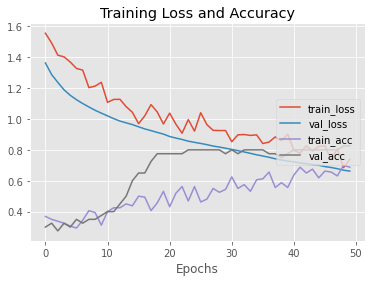

In [17]:
# Visualization (Optional)
P = model.predict(x_val, batch_size=8)
P = np.argmax(P, axis=1)
# print(classification_report(y_val.argmax(axis=1), P, target_names=label_encoder.classes_))
 
epochs = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.legend(loc="right")
plt.savefig("./s-class-plot-2.png")
 
cm = confusion_matrix(y_val.argmax(axis=1), P)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
specificity = (cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]) / (cm[1, 0] + cm[1, 1] + cm[1, 2] + cm[2, 0] + cm[2, 1] + cm[2, 2])
 
print(cm)
print(" ")
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

In [19]:
import numpy as np
import cv2
import random
import os
import json
import requests
from imutils import paths
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical

In [18]:
# Image preprocessing
imagePathTest = "./all/test"
imagePathsTest = list(paths.list_images(imagePathTest))
 
dataTest = []
labelsTest = []
 
for imagePathTest in imagePathsTest:
    labelTest = imagePathTest.split(os.path.sep)[-2]
    imageTest = cv2.imread(imagePathTest)
    imageTest = cv2.cvtColor(imageTest, cv2.COLOR_BGR2RGB)
    imageTest = cv2.resize(imageTest, (256, 256))
    dataTest.append(imageTest)
    labelsTest.append(labelTest)
     
dataTest = np.array(dataTest) / 255.0
labelsTest = np.array(labelsTest)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labelsTest)
labelsTest = to_categorical(integer_encoded)

In [20]:
# Choose a random image and make JSON
sam = random.randint(0, len(imagePathsTest)-1)
print(sam)

16


In [21]:
sample_test_data = dataTest[sam]
sample_test_labels = labelsTest[sam]
#sam 에 맞는 그림 선택 -> 256, 256, 3
sample_test_data = np.expand_dims(sample_test_data, axis=0)
# 256, 256, 3 -> 1, 256, 256, 3
data = json.dumps({"signature_name": "serving_default",
                   "instances": sample_test_data.tolist()})

In [22]:
with open("please.json", "w") as text_file:
    text_file.write("%s" % data)

In [25]:
!curl 35.230.4.132:8501/v1/models/covid/versions/1:predict -X POST -d@please.json

{
    "predictions": [[0.950093925, 0.0168375634, 0.033068575]
    ]
}